In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# --- FIX: Preserve test_df trip_id for final submission ---
# The modeling script needs the original test trip_id for the submission file.
# Save this column now before we drop it later in preprocessing.
test_raw = test_df[['trip_id']].copy()
test_raw.to_csv("test_raw.csv", index=False)
print("Saved test_raw.csv containing 'trip_id'.")

print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")


Saved test_raw.csv containing 'trip_id'.
Train Data Shape: (12654, 25)
Test Data Shape: (5852, 24)


In [3]:
missing_count = train_df['spend_category'].isnull().sum()

# 3. Check for missing values represented by empty strings (if the column is a string type)
if train_df['spend_category'].dtype == 'object':
    empty_string_count = (train_df['spend_category'] == '').sum()
else:
    empty_string_count = 0

total_missing = missing_count + empty_string_count
total_rows = len(train_df)


print(f"Total rows in train_df: {total_rows}")
print(f"Missing (NaN/None) count: {missing_count}")
print(f"Missing (Empty string) count: {empty_string_count}")
print(f"Total missing values in 'spend_category': {total_missing}")


Total rows in train_df: 12654
Missing (NaN/None) count: 34
Missing (Empty string) count: 0
Total missing values in 'spend_category': 34


In [4]:
train_df.dropna(subset=['spend_category'], inplace=True)
missing_count_1 = train_df['spend_category'].isnull().sum()

print(f"Total rows in train_df: {len(train_df)}")
print(f"Missing (NaN/None) count: {missing_count_1}")

Total rows in train_df: 12620
Missing (NaN/None) count: 0


In [5]:
# --- FIX: Modify concatenation and dropping logic ---
TARGET = 'spend_category'

# 1. Separate the target from the train features, but keep target index aligned
# This 'target' variable contains the cleaned 'spend_category' with the correct index
target = train_df[TARGET].astype(int)
train_features_df = train_df.drop(columns=[TARGET]) # Create a copy of features without target

# 2. Drop 'trip_id' ONLY from the feature sets we are processing
# This ensures train_features_df and test_features_df have identical columns for concatenation
train_features_df = train_features_df.drop('trip_id', axis=1)
test_features_df = test_df.drop('trip_id', axis=1)

# 3. Add 'source' column for splitting later
train_features_df['source'] = 'train'
test_features_df['source'] = 'test'

# 4. Concatenate for consistent preprocessing
combined_df = pd.concat([train_features_df, test_features_df], ignore_index=True)

print(f"Combined Data Shape (Features only, no trip_id/target): {combined_df.shape}")

Combined Data Shape (Features only, no trip_id/target): (18472, 24)


In [6]:
# removing columns with many missing values

missing_data = combined_df.isnull().sum()
total_rows = len(combined_df)
missing_percentage = (missing_data / total_rows) * 100
missing_summary = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_summary.to_string())

has_special_requirements    63.945431
arrival_weather             27.003032
days_booked_before_trip     11.985708
travel_companions            5.797964
total_trip_days              3.004547
country                      1.911000
insurance_included           1.851451
food_included                1.347986
intl_transport_included      1.098961
accomodation_included        1.098961
main_activity                1.044825
is_first_visit               0.741663
age_group                    0.043309
num_males                    0.032482
num_females                  0.010827


In [7]:
combined_df = combined_df.drop('has_special_requirements', axis = 1)
print(combined_df.shape)

(18472, 23)


In [8]:
numerical_cols = combined_df.select_dtypes(include=np.number).columns.tolist()
# Numerical Imputation (Median)
for col in numerical_cols:
    if combined_df[col].isnull().any():
        median_val = combined_df[col].median()
        combined_df[col].fillna(median_val, inplace=True)

/tmp/ipykernel_56547/2206975688.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[col].fillna(median_val, inplace=True)
/tmp/ipykernel_56547/2206975688.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [9]:
categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
# Remove 'source' from categorical_cols
categorical_cols.remove('source')
for col in categorical_cols:
    if combined_df[col].isnull().any():
        # Fill with a specific string for clarity, or use mode for high frequency
        combined_df[col].fillna('Missing', inplace=True)

/tmp/ipykernel_56547/332126211.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[col].fillna('Missing', inplace=True)


In [10]:
missing_data = combined_df.isnull().sum()
total_rows = len(combined_df)
missing_percentage = (missing_data / total_rows) * 100
missing_summary = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_summary.to_string())

Series([], )


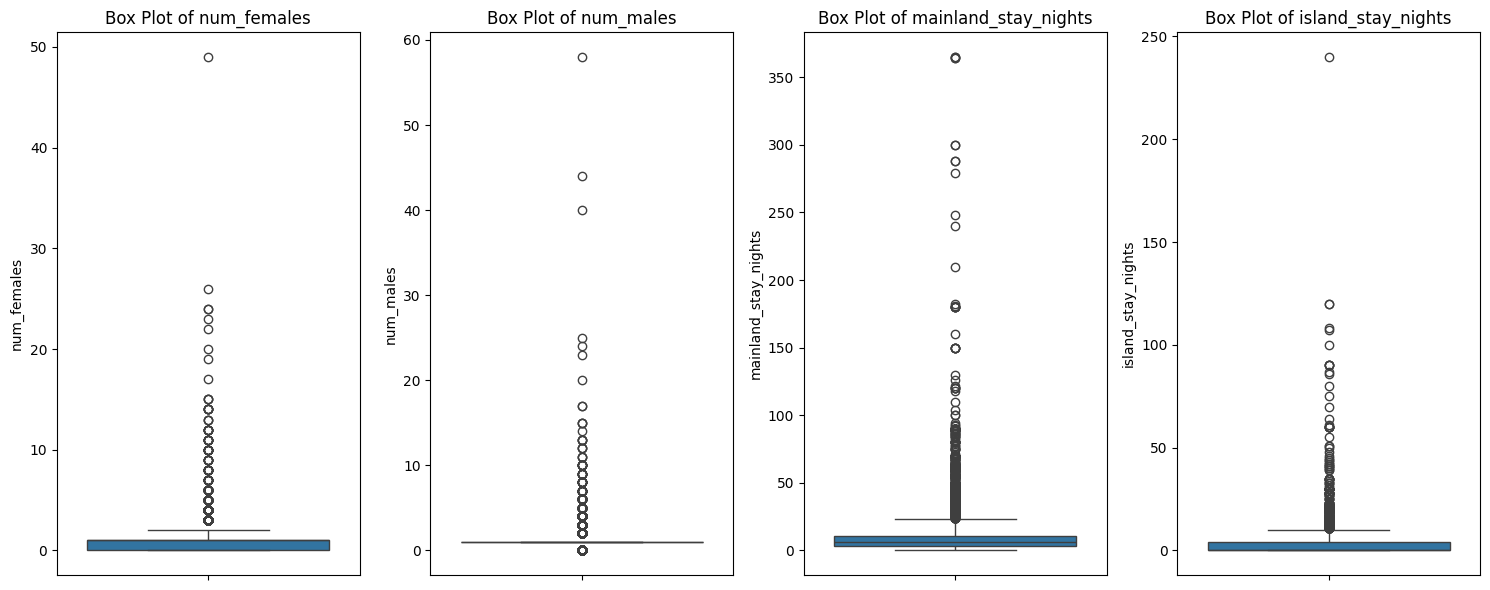

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

outlier_cols = ['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']

# Create box plots for visualization
plt.figure(figsize=(15, 6))
for i, col in enumerate(outlier_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=combined_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show() #

Interquartile Range (IQR) method
Any data point that falls outside the range below will be capped or removed:

$$[Q1 - 1.5 \times IQR, \quad Q3 + 1.5 \times IQR]$$

In [12]:
def cap_outliers_iqr(df, column):
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper bound for capping
    upper_bound = Q3 + 1.5 * IQR

    # Define the lower bound (often 0 for count/time data)
    lower_bound = Q1 - 1.5 * IQR
    if lower_bound < 0:
        lower_bound = 0

    # Cap the values
    # If a value > upper_bound, set it to upper_bound. Otherwise, keep original.
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)
    return df

# Apply the capping function to the relevant columns in the combined DataFrame
numerical_cols_to_cap = ['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']

for col in numerical_cols_to_cap:
    combined_df = cap_outliers_iqr(combined_df, col)
    

# Note: You should re-run your full data preparation script 
# with this updated capping logic incorporated in step 2.

In [13]:
# Total number of travelers
combined_df['total_travelers'] = combined_df['num_females'] + combined_df['num_males']

# Total stay nights
combined_df['total_stay_nights'] = combined_df['mainland_stay_nights'] + combined_df['island_stay_nights']

# Trip Type feature
def get_trip_type(row):
    is_mainland = row['mainland_stay_nights'] > 0
    is_island = row['island_stay_nights'] > 0
    if is_mainland and is_island:
        return 'Both'
    elif is_mainland:
        return 'Mainland Only'
    elif is_island:
        return 'Island Only'
    else:
        return 'No Stay'
combined_df['trip_type'] = combined_df.apply(get_trip_type, axis=1)
categorical_cols.append('trip_type')

ORDINAL MAPPING

Mapping range columns to mid point of the range

In [14]:
def map_range_to_midpoint(range_str):
    if pd.isna(range_str) or range_str in ['Missing', 'none', '30+','90+']:
        # Assign a default large value for '30+' and '90+' or 0 for 'none'
        if '30+' in str(range_str): return 45 # Midpoint of 30-60
        if '90+' in str(range_str): return 100 # Default large value
        if 'none' in str(range_str): return 0
        return 0 # Default for 'Missing'
    try:
        if '-' in range_str:
            start, end = map(float, re.findall(r'\d+', range_str))
            return (start + end) / 2
        else: # Handle single number values if they exist
            return float(range_str)
    except:
        return 0

# Mapping days_booked_before_trip
combined_df['days_booked_midpoint'] = combined_df['days_booked_before_trip'].apply(map_range_to_midpoint)

# Mapping total_trip_days
combined_df['total_trip_days_midpoint'] = combined_df['total_trip_days'].apply(map_range_to_midpoint)

# Mapping age_group (a simpler Ordinal feature)
age_mapping = {'<18': 10, '18-24': 21, '25-44': 35, '45-64': 55, '65+': 70, 'Missing': 0}
combined_df['age_group_ordinal'] = combined_df['age_group'].map(age_mapping).fillna(0)


# Drop original ordinal columns
combined_df = combined_df.drop(['days_booked_before_trip', 'total_trip_days', 'age_group'], axis=1)

One-Hot Encoding

In [15]:
# --- NEW CODE BLOCK: ONE-HOT ENCODING ---

# Assuming 'combined_df' now contains all cleaned and imputed features, plus the 'source' column.

# 1. Separate 'source' column for splitting
source_col = combined_df['source']
combined_df = combined_df.drop(columns=['source'])

# 2. Perform One-Hot Encoding on all remaining object columns
# This transforms remaining categorical columns into a numerical format.
categorical_cols_to_encode = combined_df.select_dtypes(include=['object']).columns.tolist()
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols_to_encode, drop_first=True, dtype=int)

# 3. Re-attach the 'source' column for splitting
combined_df_encoded['source'] = source_col

print(f"Encoded Combined Data Shape: {combined_df_encoded.shape}")


# --- NEW CODE BLOCK: SPLITTING AND SAVING ---
TARGET = 'spend_category'

# 1. Split back into Training Features and Test Features
train_processed = combined_df_encoded[combined_df_encoded['source'] == 'train'].drop(columns=['source'])
test_processed = combined_df_encoded[combined_df_encoded['source'] == 'test'].drop(columns=['source'])

# 2. Align the index of the training features to the target and add the target column back
# This alignment is necessary because we dropped rows with NaN in the target earlier.
train_processed.index = target.index
train_processed[TARGET] = target # Include target in the final processed training file

# 3. Save Final Processed Files
train_processed.to_csv("train_processed.csv", index=False)
test_processed.to_csv("test_processed.csv", index=False)

print("\nFinished Preprocessing and saving files.")
print(f"train_processed.csv saved with shape: {train_processed.shape}")
print(f"test_processed.csv saved with shape: {test_processed.shape}")

Encoded Combined Data Shape: (18472, 193)

Finished Preprocessing and saving files.
train_processed.csv saved with shape: (12620, 193)
test_processed.csv saved with shape: (5852, 192)
